### Make sure you have saved the featuremaps(activations) to npy files

In [33]:
import numpy as np
from scipy import linalg

fake = np.load(r'ground truth_motion_embeddings.npy')
real = np.load(r'gt_motion_embeddings.npy')

print(f'shape of fake: {fake.shape}')
print(f'shape of real: {real.shape}')

assert len(fake.shape) == 2

shape of fake: (4640, 512)
shape of real: (4640, 512)


### for some reason, the featuremaps might contain nan values, so we need to remove them
Here we remove by the row

In [34]:
remov_rows = []

if np.isnan(real).any():
    for i in range(real.shape[0]):
        for j in range(real.shape[1]):
            if np.isnan(real[i][j]):
                # print(i, j)
                remov_rows.append(i)
                break
real_safe = np.delete(real, remov_rows, axis=0)
print('Is there any nan left in the featuremap?', np.isnan(real_safe).any())

remov_rows = []
if np.isnan(fake).any():
    for i in range(real.shape[0]):
        for j in range(real.shape[1]):
            if np.isnan(fake[i][j]):
                # print(i, j)
                remov_rows.append(i)
                break
fake_safe = np.delete(fake, remov_rows, axis=0)
print('Is there any nan left in the featuremap?', np.isnan(fake_safe).any())

Is there any nan left in the featuremap? False
Is there any nan left in the featuremap? False


### Hypothsis Tests

In [35]:
from scipy import stats

In [24]:
# shapiro-wilk test
# null hypothesis: the sample is drawn from a normal distribution
# once sample amount is more than 5000, shapiro-wilk test will be not reliable

import scipy
real_not_normal = 0
fake_not_normal = 0
for i in range(real_safe.shape[1]):
    x = real_safe[:, i]
    if scipy.stats.shapiro(x)[1] < 0.05:
        real_not_normal += 1

for i in range(fake_safe.shape[1]):
    x = fake_safe[:, i]
    if scipy.stats.shapiro(x)[1] < 0.05:
        fake_not_normal += 1
        
print(real_not_normal, fake_not_normal)

512 512


In [36]:
# Kolmogorov-Smirnov test
# null hypothesis: the two distributions are identical(default, two-sided)
# tests are valid only for continuous distributions
### if p-value < 0.05, the distribution is not identical to a normal distribution

from scipy.stats import kstest
normal_dist = np.random.randn(1000)
print(kstest(real_safe[:, 0],"norm"))   # here we use the first dimension of feature map for demonstration, should change it to all dimension
print(kstest(fake_safe[:, 0],"norm"))

KstestResult(statistic=0.6854416477550414, pvalue=0.0)
KstestResult(statistic=0.6860500637645296, pvalue=0.0)


In [37]:
# D’Agostino and Pearson’s
# null hypothesis: a sample comes from a normal distribution
### if p-value < 0.05, the distribution is not identical to a normal distribution

from scipy.stats import normaltest
normaltest(real_safe[:, 0])     # here we use the first dimension of feature map for demonstration, should change it to all dimension

NormaltestResult(statistic=76.13355504777446, pvalue=2.936355119691995e-17)

### Illustrative Test

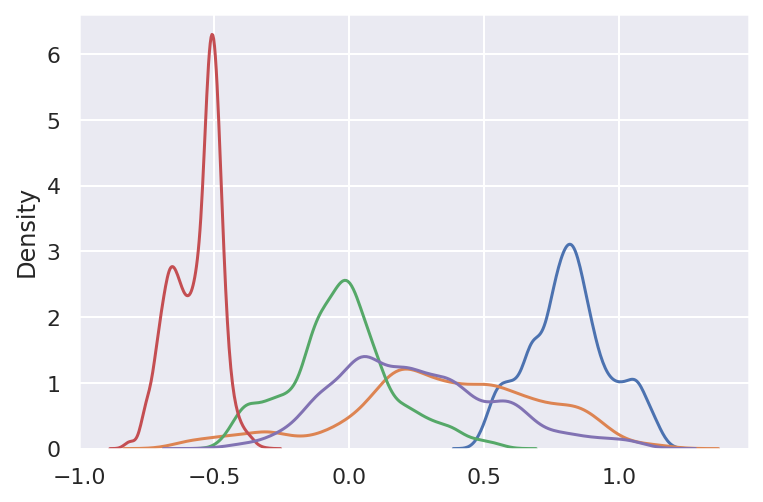

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

for i in range(5):      # we illustrate the first 5 dimensions of feature map to see if they are normal distributed
    x = real_safe[:, i]
    sns.kdeplot(x, shade=False)

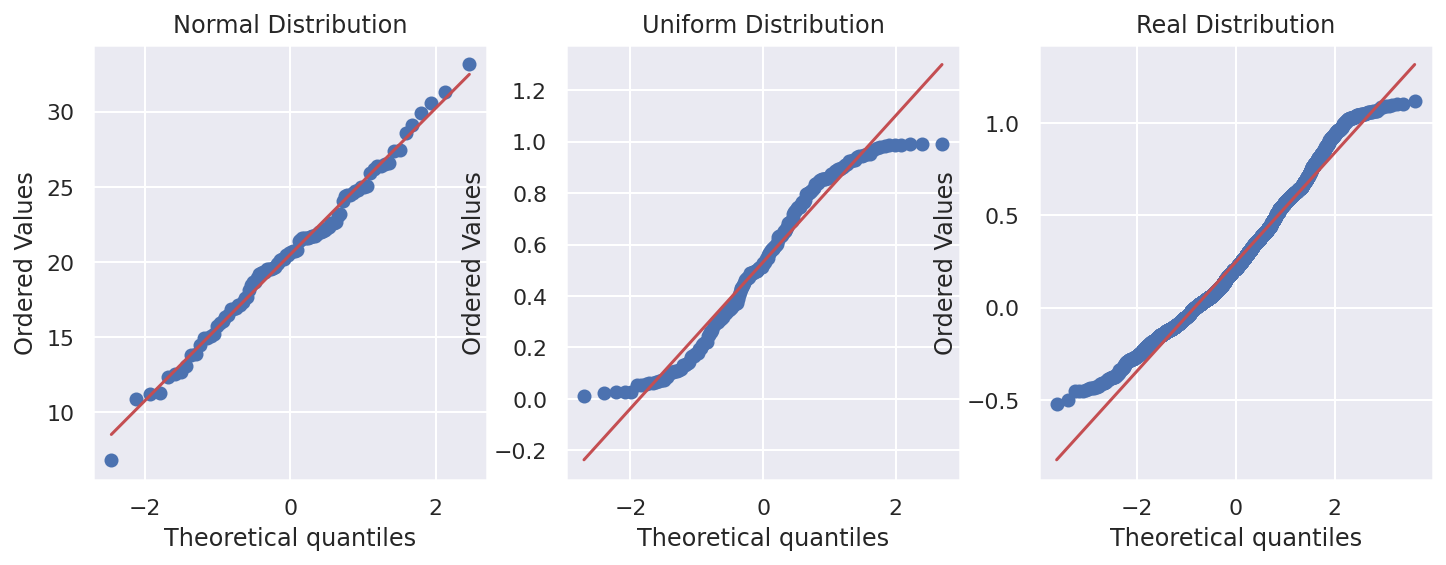

In [39]:
# probplot, PP plot 
### The PP plot of read data should be similar to that of ideal normal distribution

import numpy as np 
import pylab 
import scipy.stats as stats

data_normal = np.random.normal(loc = 20, scale = 5, size=100)      # ideal normal distribution
data_real = real_safe[:, i]      # real distribution
data_uni = np.random.rand(200)      # uniform distribution

plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 3, 1)
stats.probplot(data_normal, dist="norm", plot=pylab)
ax1.set_title("Normal Distribution")

ax2 = plt.subplot(1, 3, 2)
stats.probplot(data_uni, dist="norm", plot=pylab)
ax2.set_title("Uniform Distribution")

ax3 = plt.subplot(1, 3, 3)
stats.probplot(data_real, dist="norm", plot=pylab)
ax3.set_title("Real Distribution")

pylab.show()

/opt/tljh/user/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/tljh/user/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/opt/tljh/user/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


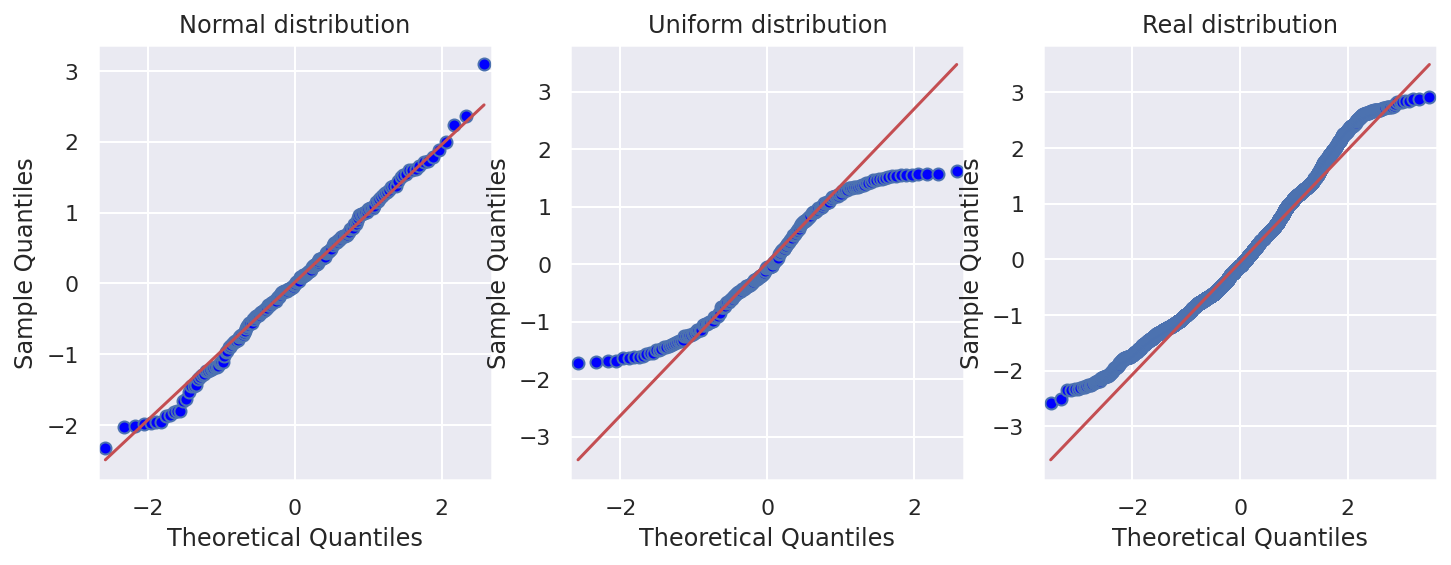

In [40]:
# qqplot
# not that ppplot and qqplot are different
### The QQ plot of read data should be similar to that of ideal normal distribution

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.api import qqplot
 
sns.set_theme()
%config InlineBackend.figure_format = 'retina'
 
mu, sigma = 0, 1
data_normal = np.random.normal(mu, sigma, 200)
data_uni = np.random.rand(200)
data_real = real_safe[:, i]

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
fig = qqplot(data_normal, line="q", ax=ax1, fit=True)
ax1.set_title("Normal distribution")

ax2 = fig.add_subplot(132)
fig = qqplot(data_uni, line="q", ax=ax2, fit=True)
ax2.set_title("Uniform distribution")

ax3 = fig.add_subplot(133)
fig = qqplot(data_real, line="q", ax=ax3, fit=True)
ax3.set_title("Real distribution")

plt.show()

### Calculate the FID score

In [41]:
real = real_safe
fake = fake_safe

n1 = fake.shape[0]
n2 = real.shape[0]

mean_fake = np.mean(real, axis=0)[None, ...]
mean_real = np.mean(fake, axis=0)[None, ...]

cov_fake_sum = fake.T @ fake - n1 * mean_fake.T @ mean_fake
cov_real_sum = real.T @ real - n2 * mean_real.T @ mean_real

cov_fake = cov_fake_sum / (n1 - 1)
cov_real = cov_real_sum / (n2 - 1)

In [42]:
mu1, mu2, sig1, sig2 = mean_fake, mean_real, cov_fake, cov_real

In [43]:
import torch

mu1_tensor = torch.tensor(mu1)
mu2_tensor = torch.tensor(mu2)
sig1_tensor = torch.tensor(sig1)
sig2_tensor = torch.tensor(sig2) 

a = (mu1_tensor - mu2_tensor).square().sum(dim=-1)
b = sig1_tensor.trace() + sig2_tensor.trace()
c = torch.linalg.eigvals(sig1_tensor @ sig2_tensor).sqrt().real.sum(dim=-1)

a + b - 2 * c

tensor([-0.6252])